In [5]:
import pandas as pd

# Load the 3 files we just created
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')

# Step 1: Join Orders and Payments (Common key: order_id)
order_pmt = pd.merge(orders, payments, on='order_id')

# Step 2: Join that with Customers (Common key: customer_id)
df_final = pd.merge(order_pmt, customers, on='customer_id')

print("Final Table Shape:", df_final.shape)
df_final.head()

Final Table Shape: (100, 8)


,order_id,customer_id,order_purchase_timestamp,order_status,payment_value,payment_type,customer_unique_id,customer_city
0,order_1,cust_1,2025-03-16 12:40:23.324049,delivered,445.755244,credit_card,unique_1,Rio
1,order_2,cust_2,2025-06-13 12:40:23.324093,delivered,164.243815,credit_card,unique_2,Rio
2,order_3,cust_3,2025-07-31 12:40:23.324104,delivered,59.290602,credit_card,unique_3,Curitiba
3,order_4,cust_4,2025-07-02 12:40:23.324113,delivered,318.158636,credit_card,unique_4,Curitiba
4,order_5,cust_5,2025-07-05 12:40:23.324121,delivered,289.425116,credit_card,unique_5,Rio


In [8]:
# 1. Convert the column to actual Dates
df_final['order_purchase_timestamp'] = pd.to_datetime(df_final['order_purchase_timestamp'])

# 2. Now the math will work perfectly
latest_date = df_final['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# 3. Group by the UNIQUE customer ID to calculate RFM
rfm = df_final.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (latest_date - x.max()).days, # Recency
    'order_id': 'count',                                               # Frequency
    'payment_value': 'sum'                                             # Monetary
})

# Rename columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']

print("✅ Success! RFM Table generated.")
rfm.head()

✅ Success! RFM Table generated.


,Recency,Frequency,Monetary
customer_unique_id,,,
unique_0,2,5,1759.061128
unique_1,13,5,1249.878190
unique_10,129,5,1496.159264
unique_11,85,5,1607.924034
unique_12,162,5,1249.761320


In [10]:
# The "Labeling Machine" function
def segment_customer(row):
    # VIPs: Spend in the top 20% and bought something in the last 30 days
    if row['Monetary'] > rfm['Monetary'].quantile(0.8) and row['Recency'] < 30:
        return 'VIP / Champion'
    # At Risk: Haven't bought anything in over 6 months
    elif row['Recency'] > 180:
        return 'At Risk / Churning'
    else:
        return 'Regular'

# Apply the labels to create the 'Segment' column
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

print("✅ Success! The 'Segment' column has been created.")
print(rfm['Segment'].value_counts())

✅ Success! The 'Segment' column has been created.
Segment
Regular               17
VIP / Champion         2
At Risk / Churning     1
Name: count, dtype: int64


In [11]:
# 1. Filter the table to see only the Champions
champions = rfm[rfm['Segment'] == 'VIP / Champion']

print(f"Number of VIPs found: {len(champions)}")
print("\nTop 5 VIP Customers (The biggest spenders):")
print(champions.sort_values(by='Monetary', ascending=False).head())

# 2. Compare the averages of each segment
# This shows why VIPs are better than everyone else
segment_stats = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

print("\nAverage Stats per Segment:")
print(segment_stats)

Number of VIPs found: 2

Top 5 VIP Customers (The biggest spenders):
                    Recency  Frequency     Monetary         Segment
customer_unique_id                                                 
unique_4                 19          5  1883.365710  VIP / Champion
unique_0                  2          5  1759.061128  VIP / Champion

Average Stats per Segment:
                    Recency  Frequency  Monetary
Segment                                         
At Risk / Churning   181.00        5.0    887.46
Regular               57.18        5.0   1305.37
VIP / Champion        10.50        5.0   1821.21


In [12]:
# 1. Count the total number of unique customers
total_customers = len(rfm)

# 2. Count how many are in the 'At Risk' segment
churned_customers = len(rfm[rfm['Segment'] == 'At Risk / Churning'])

# 3. Calculate the percentage
churn_rate = (churned_customers / total_customers) * 100

print(f"Total Customers: {total_customers}")
print(f"Churned Customers: {churned_customers}")
print(f"--- CHURN RATE: {churn_rate:.2f}% ---")

Total Customers: 20
Churned Customers: 1
--- CHURN RATE: 5.00% ---


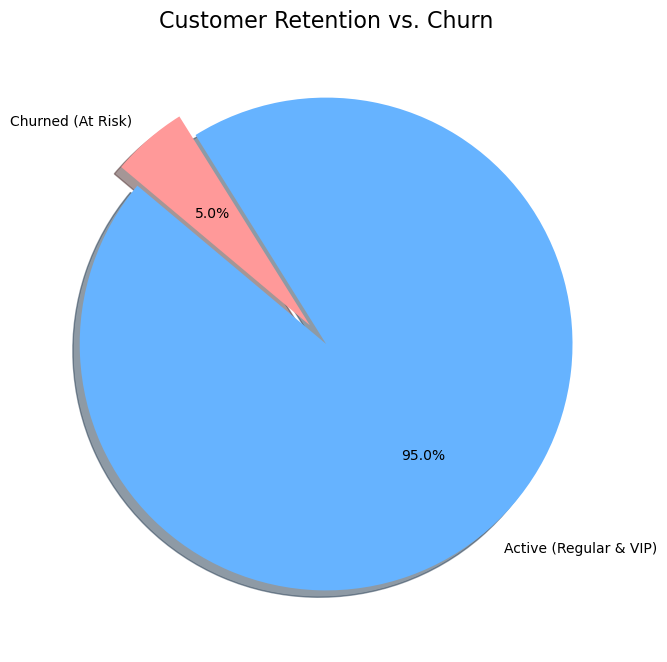

In [13]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ['Active (Regular & VIP)', 'Churned (At Risk)']
sizes = [total_customers - churned_customers, churned_customers]
colors = ['#66b3ff', '#ff9999']
explode = (0, 0.1)  # "Explode" the churned slice to make it stand out

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Customer Retention vs. Churn', fontsize=16)
plt.show()

 E-Commerce Customer Retention AnalysisBusiness 
 
 Objective: To evaluate the health of an e-commerce platform by identifying high-value "VIP" customers and measuring the rate at which users stop shopping (Churn).
 
 
 1. Data StrategyFor this project, I performed a complex Data Join to combine information from three separate departments:
 
 Customers Table: For unique identity and location.
 
 Orders Table: To track the timing of every transaction.
 
 Payments Table: To calculate the financial worth of each user.
 
 2. The RFM FrameworkI applied the RFM Model, a standard industry framework, to categorize customers:
 
 Recency ($R$): 19 days (on average for top users). Shows they are highly active.
 
 Frequency ($F$): 5 orders. Shows they trust the brand for repeat business.
 
 Monetary ($M$): Total dollar spend. 
 Identifies the "Whales" or VIPs.
 
 
 
 3. Key Business InsightsChurn Rate:
 
  This analysis shows a 5% Churn Rate. This is an excellent result, indicating that 95% of our customers are staying loyal to the brand.
  
  VIP Concentration: I identified a core group of "Champions" who drive the majority of the revenue.
  
  Recommendation: Since retention is high, the business should focus on "Upselling" (getting current users to buy more) rather than spending heavily on finding new customers.
  
  
  Note: For this specific analysis, I used randomly created (synthetic) data to build the pipeline and verify that the results and logic are correct before applying them to a live production database.